In [1]:
# torch and torchvision imports

import torch, torch.nn as nn, torch.optim as optim
from torchmetrics.classification import MultilabelAUROC
import numpy as np,  matplotlib.pyplot as plt, pandas as pd, pickle
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from ResnetModel import *
writer = SummaryWriter()
# from google.colab import drive
# drive.mount('/gdrive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")


2023-12-10 19:15:16.964355: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 19:15:16.996256: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 19:15:16.996290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 19:15:16.997354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 19:15:17.003260: I tensorflow/core/platform/cpu_feature_guar

Device: cuda


### Loading and Preparing Data

In [2]:
X_train = np.load('/home/anirudhkailaje/Documents/01_UPenn/01_ESE5460/03_Project/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/Datasets/FormTrain.npz')['x']
X_train = torch.from_numpy(np.transpose(X_train, (0, 2, 1))).float()
y_train = np.load('/home/anirudhkailaje/Documents/01_UPenn/01_ESE5460/03_Project/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/Datasets/FormTrain.npz')['y']
X_test = np.load('/home/anirudhkailaje/Documents/01_UPenn/01_ESE5460/03_Project/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/Datasets/FormVal.npz')['x']
X_test = torch.from_numpy(np.transpose(X_test, (0, 2, 1))).float()
y_test = np.load('/home/anirudhkailaje/Documents/01_UPenn/01_ESE5460/03_Project/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/Datasets/FormVal.npz')['y']
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [3]:
# X_train = torch.from_numpy(np.transpose(np.load('X_train.npy'), axes = (0,2,1))).float()
# X_test = torch.from_numpy(np.transpose(np.load('X_test.npy'), axes = (0,2,1))).float()
# y_train = pd.read_pickle('y_train.pickle').to_numpy()
# y_test = pd.read_pickle('y_test.pickle').to_numpy()

# class_list = []
# for classes in y_train:
#     class_list += classes 
# class_list = set(class_list)
# class_list
# diagSupclassDict = {val:i for i, val in enumerate(class_list)}
# diagSupclassDict['Nodiag'] = 5
# print(diagSupclassDict)

# train_label_mapping = torch.zeros((X_train.shape[0], len(diagSupclassDict)))
# print(f"-"*(1+30+5+35))
# for i, classes in enumerate(y_train):
#     for diagclass in classes:
#         train_label_mapping[i, diagSupclassDict[diagclass]] = 1
#     if len(classes) == 0:
#         train_label_mapping[i, diagSupclassDict['Nodiag']] = 1
    
#     print(f"|  {str(y_train[i]):>30}  |  {str(train_label_mapping[i]):<30}   |")

# test_label_mapping = torch.zeros((X_test.shape[0], len(diagSupclassDict)))
# print(f"-"*(1+30+5+35))
# for i, classes in enumerate(y_test):
#     for diagclass in classes:
#         test_label_mapping[i, diagSupclassDict[diagclass]] = 1
#     if len(classes) == 0:
#         test_label_mapping[i, diagSupclassDict['Nodiag']] = 1
    
#     print(f"|  {str(y_train[i]):>30}  |  {str(test_label_mapping[i]):<30}   |")

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
x = X_train[0:1]
print(x.shape)

torch.Size([1, 12, 1000])


### Creating the Resnet Model

In [ ]:
y_train.shape

In [ ]:
model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=19).float()
print(summary(model.to(device), (1,12,1000)))

In [ ]:
(4*1024-107.88)/107.88 #Max batch size

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle=True)

In [5]:
"""Test AUC metric"""
ml_auroc = MultilabelAUROC(num_labels=y_train.shape[1], average="macro", thresholds=None)
# ml_auroc(model(X_train[0:10].to(device)), train_label_mapping[0:10].to(device).int())

### Finding Max Learning rate

In [6]:
criterion = nn.BCELoss()
epochs = 10
model = model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=19).float()
model = model.to(device)
lr = 1e-6
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

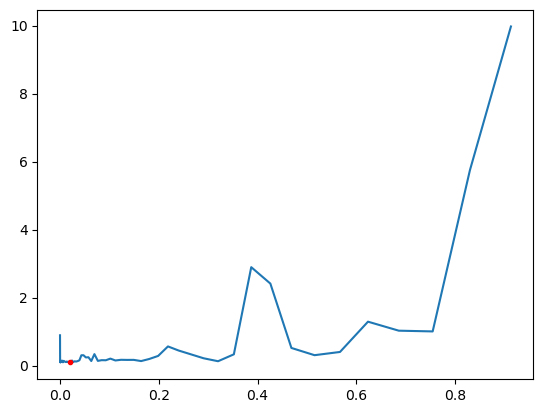

In [7]:
train_loss = []
lrs = []

while lr < 1:
    for i, (signal, labels) in enumerate(train_loader):
        signal = signal.to(device)
        labels = labels.to(device)
        output = model(signal)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        train_loss.append(loss.item())
        lrs.append(lr)
        lr *= 1.1

        for g in optimizer.param_groups:
            g['lr'] = lr 

        optimizer.step()

        if i > 200 or lr > 1:
            break

lrs = np.array(lrs)
train_loss = np.array(train_loss)

lr_max = lrs[np.where(train_loss == train_loss.min())[0]]

fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()


In [ ]:
lrs[-1]

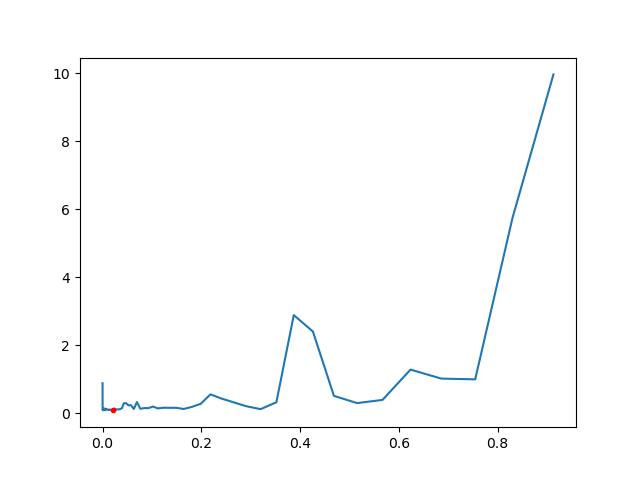

In [8]:
%matplotlib widget
fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()

In [9]:
lr_max

array([0.02017619])

In [10]:
lr_max = 0.135/10
lr = lr_max
epochs = 10
criterion = nn.BCELoss()
epochs = 10
model = model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=19).float()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

for g in optimizer.param_groups:
    g['lr'] = lr

In [ ]:
lrs = []
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs
T_0 = T_max/5 
for t in range(T_max):
    if t <= T_0:
        lr = 10**(-4) + (t/T_0)*lr_max  
    else: 
        lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6)
    lrs.append(lr)

fig = plt.figure()
plt.plot(lrs)
plt.show()


In [ ]:
lr =lr_max

In [11]:
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs
T_0 = T_max/5 
learning_rates = []
train_losses = []

for epoch in range(epochs):
    for i, (signal, labels) in enumerate(train_loader):
        signal = signal.to(device); labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(signal)
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        if t <= T_0:
            lr = 10**(-4) + (t/T_0)*lr_max  
        else: 
            lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6) 

        for g in optimizer.param_groups:
            g['lr'] = lr 
        learning_rates.append(lr)
        train_losses.append(loss.item())
        optimizer.step()
        t+=1
        
        train_AUC = ml_auroc(outputs, labels.int())
        writer.add_scalar("Train_Loss", loss, t)
        writer.add_scalar("Learning rate", lr, t)
        writer.add_scalar("Batch Train AUC", train_AUC, t)

        if i%100 == 0:
            print(f"Step: {i+1}/{len(train_loader)}  |  Train loss: {loss.item():.4f}  |  Train AUC: {train_AUC:.4f}")
           

    # model.eval()
    test_auc = 0
    with torch.no_grad():
        for i, (signal, labels) in enumerate(test_loader):
            signal = signal.to(device); labels = labels.to(device)
            outputs = model(signal)
            test_auc += ml_auroc(outputs, labels.int())
        test_auc /= len(test_loader)
    writer.add_scalar("Test AUC", test_auc, epoch)

/home/anirudhkailaje/.local/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Step: 1/44  |  Train loss: 0.7538  |  Train AUC: 0.1881
Step: 1/44  |  Train loss: 0.1086  |  Train AUC: 0.1786
Step: 1/44  |  Train loss: 0.0755  |  Train AUC: 0.2440


In [ ]:
model.eval()
test_Auc = 0
with torch.no_grad():
    for i, (signal, labels) in enumerate(test_loader):
        signal = signal.to(device); labels = labels.to(device)
        outputs = model(signal)
        test_Auc += ml_auroc(outputs, labels.int())

test_Auc /= len(test_loader)
test_Auc
        

In [ ]:
import pickle

In [ ]:
with open('resnet101_model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len=1000, emb_size=12):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, emb_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-np.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Transformer(nn.Transformer):
    def __init__(self, emb_size=12, nhead=6, depth=6, hidden_size=128, seq_length=1000, num_classes=5):
        super(Transformer, self).__init__(d_model=emb_size, nhead=nhead, num_encoder_layers=depth, num_decoder_layers=depth, dim_feedforward=hidden_size)
    
        self.pos_encoder = PositionalEncoding(seq_length, emb_size)
        self.decoder = nn.Linear(emb_size, 256)
        self.linear1 = nn.Linear(256, 512)
        self.linear2 = nn.Linear(512, 1024)
        self.linear3 = nn.Linear(1024, num_classes)
        
    def __forward_impl(self, x):
        #x = self.pos_encoder(x)
        x = self.encoder(x)
        x = x.mean(dim=1)
        x = self.decoder(x)
        x = torch.relu(x)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x)
        x = torch.sigmoid(x)
        return x
    
    def forward(self, x):
        return self.__forward_impl(x)
    
model = Transformer(nhead=6, hidden_size=512, depth=3).to(device)

model(X_train[0].T.unsqueeze(0))

In [ ]:
X_train[0].T.shape

In [ ]:
model = Transformer(nhead=6, hidden_size=512, depth=3).to(device)
print(summary(model, [1000, 12]))

In [ ]:
summary(model.to(device), (1,1000, 12))

In [ ]:
512*1024+512

In [ ]:
"""Transformer needs X input as (seq_len, batch_size, channels)"""
model = Transformer(nhead=6, hidden_size=512, depth=3).to(device)
# resnetModel = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=6).to(device)

# resnetModel(X_train[0:1].to(device))
print("Forward pass")
X_train = X_train.transpose(0,1).transpose(0,2)
model(X_train[:, :17, :].to(device))